# 26a: Threshold Cliffs Analysis

**Claim**: Folk wisdom says:
- 30→31 threshold is "about losing one 10-count"
- 35→36 threshold is "about losing one 5-count"

**Method**: 
1. Use unified features (V_mean, V_std) to compute P(make bid) using normal approximation
2. Calculate Δ(P) = P(make n) - P(make n+1) for adjacent levels
3. Test if Δ(30→31) and Δ(35→36) show larger drops than neighboring transitions

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Unified Features

We use V_mean and V_std from the unified features file (200 hands).

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
features_df = pd.read_csv(features_path)

print(f"Loaded {len(features_df)} hands")
print(f"Columns: {list(features_df.columns)[:10]}...")

# Key columns for threshold analysis
print(f"\nV_mean range: [{features_df['V_mean'].min():.1f}, {features_df['V_mean'].max():.1f}]")
print(f"V_std range: [{features_df['V_std'].min():.1f}, {features_df['V_std'].max():.1f}]")

Loaded 200 hands
Columns: ['base_seed', 'decl_id', 'trump_suit', 'V_mean', 'V_std', 'V_spread', 'V_min', 'V_max', 'n_doubles', 'trump_count']...

V_mean range: [-29.3, 42.0]
V_std range: [0.0, 37.7]


## 2. Compute P(make bid) Using Normal Approximation

For each hand with V_mean and V_std, approximate:
```
P(make bid B) = P(V >= B) ≈ 1 - Φ((B - V_mean) / V_std)
```
where Φ is the standard normal CDF.

In [3]:
BID_LEVELS = list(range(30, 43))  # 30 through 42

def compute_p_make_normal(v_mean, v_std, bid):
    """Compute P(make bid) using normal approximation."""
    if v_std <= 0:
        return 1.0 if v_mean >= bid else 0.0
    z = (bid - v_mean) / v_std
    return 1 - stats.norm.cdf(z)

# Compute P(make) for each hand and bid level
p_make_data = []

for _, row in features_df.iterrows():
    v_mean = row['V_mean']
    v_std = row['V_std']
    p_row = {'seed': row['base_seed'], 'V_mean': v_mean, 'V_std': v_std}
    
    for bid in BID_LEVELS:
        p_row[f'p_make_{bid}'] = compute_p_make_normal(v_mean, v_std, bid)
    
    p_make_data.append(p_row)

p_make_df = pd.DataFrame(p_make_data)
print(f"P(make) matrix shape: {p_make_df.shape}")

P(make) matrix shape: (200, 16)


In [4]:
# Compute average P(make) across all hands
avg_p_make = {}
for bid in BID_LEVELS:
    avg_p_make[bid] = p_make_df[f'p_make_{bid}'].mean()

print("Average P(make bid) across all hands:")
print("="*40)
for bid in BID_LEVELS:
    print(f"  Bid {bid}: {avg_p_make[bid]*100:5.1f}%")

Average P(make bid) across all hands:
  Bid 30:  28.4%
  Bid 31:  26.9%
  Bid 32:  25.4%
  Bid 33:  23.9%
  Bid 34:  22.5%
  Bid 35:  21.0%
  Bid 36:  19.4%
  Bid 37:  17.8%
  Bid 38:  16.2%
  Bid 39:  14.4%
  Bid 40:  12.7%
  Bid 41:  11.1%
  Bid 42:   9.6%


## 3. Compute Threshold Drops (Δ)

In [5]:
TRANSITIONS = [(b, b+1) for b in BID_LEVELS[:-1]]

delta_data = []
for _, row in p_make_df.iterrows():
    delta_row = {'seed': row['seed']}
    for b_low, b_high in TRANSITIONS:
        delta_row[f'delta_{b_low}_{b_high}'] = row[f'p_make_{b_low}'] - row[f'p_make_{b_high}']
    delta_data.append(delta_row)

delta_df = pd.DataFrame(delta_data)

# Average deltas
avg_deltas = {}
for b_low, b_high in TRANSITIONS:
    col = f'delta_{b_low}_{b_high}'
    avg_deltas[(b_low, b_high)] = {
        'mean': delta_df[col].mean(),
        'std': delta_df[col].std(),
    }

print("Average Δ(P) at each transition:")
print("="*50)
for (b_low, b_high), s in avg_deltas.items():
    print(f"{b_low}→{b_high:2d}:  Mean {s['mean']*100:8.2f}%  Std {s['std']*100:7.2f}%")

Average Δ(P) at each transition:
30→31:  Mean     1.50%  Std    1.53%
31→32:  Mean     1.48%  Std    1.58%
32→33:  Mean     1.48%  Std    1.67%
33→34:  Mean     1.48%  Std    1.76%
34→35:  Mean     1.48%  Std    1.82%
35→36:  Mean     1.54%  Std    2.27%
36→37:  Mean     1.63%  Std    3.29%
37→38:  Mean     1.66%  Std    3.01%
38→39:  Mean     1.74%  Std    3.93%
39→40:  Mean     1.72%  Std    4.08%
40→41:  Mean     1.63%  Std    3.76%
41→42:  Mean     1.48%  Std    4.25%


## 4. Statistical Test for Threshold Cliffs

In [6]:
KEY_TRANSITIONS = [
    (30, 31, "10-count cliff"),
    (35, 36, "5-count cliff"),
]

delta_cols = [f'delta_{b}_{b+1}' for b in BID_LEVELS[:-1]]
non_key_cols = [c for c in delta_cols if c not in ['delta_30_31', 'delta_35_36']]
baseline_mean = delta_df[non_key_cols].values.flatten().mean()

print(f"Baseline mean Δ (excluding key transitions): {baseline_mean*100:.3f}%")
print("\n" + "="*60)
print("THRESHOLD CLIFF ANALYSIS")
print("="*60)

results = []
for b_low, b_high, description in KEY_TRANSITIONS:
    col = f'delta_{b_low}_{b_high}'
    key_deltas = delta_df[col].values
    key_mean = key_deltas.mean()
    
    # t-test
    t_stat, p_value = stats.ttest_1samp(key_deltas, baseline_mean)
    
    # Bootstrap CI
    excess_samples = []
    for _ in range(1000):
        sample = np.random.choice(key_deltas, size=len(key_deltas), replace=True)
        excess_samples.append(sample.mean() - baseline_mean)
    ci_low, ci_high = np.percentile(excess_samples, [2.5, 97.5])
    
    excess = key_mean - baseline_mean
    sig = "✓ SIGNIFICANT" if p_value < 0.05 else "✗ Not significant"
    
    print(f"\n{description} ({b_low}→{b_high}):")
    print(f"  Mean Δ: {key_mean*100:.3f}% (baseline: {baseline_mean*100:.3f}%)")
    print(f"  Excess: {excess*100:+.3f}% (95% CI: [{ci_low*100:.3f}%, {ci_high*100:.3f}%])")
    print(f"  p-value: {p_value:.4f} {sig}")
    
    results.append({
        'transition': f'{b_low}→{b_high}',
        'description': description,
        'mean_delta': key_mean,
        'baseline_delta': baseline_mean,
        'excess': excess,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

Baseline mean Δ (excluding key transitions): 1.577%

THRESHOLD CLIFF ANALYSIS

10-count cliff (30→31):
  Mean Δ: 1.498% (baseline: 1.577%)
  Excess: -0.079% (95% CI: [-0.278%, 0.131%])
  p-value: 0.4676 ✗ Not significant

5-count cliff (35→36):
  Mean Δ: 1.539% (baseline: 1.577%)
  Excess: -0.038% (95% CI: [-0.323%, 0.296%])
  p-value: 0.8120 ✗ Not significant


## 5. Visualization

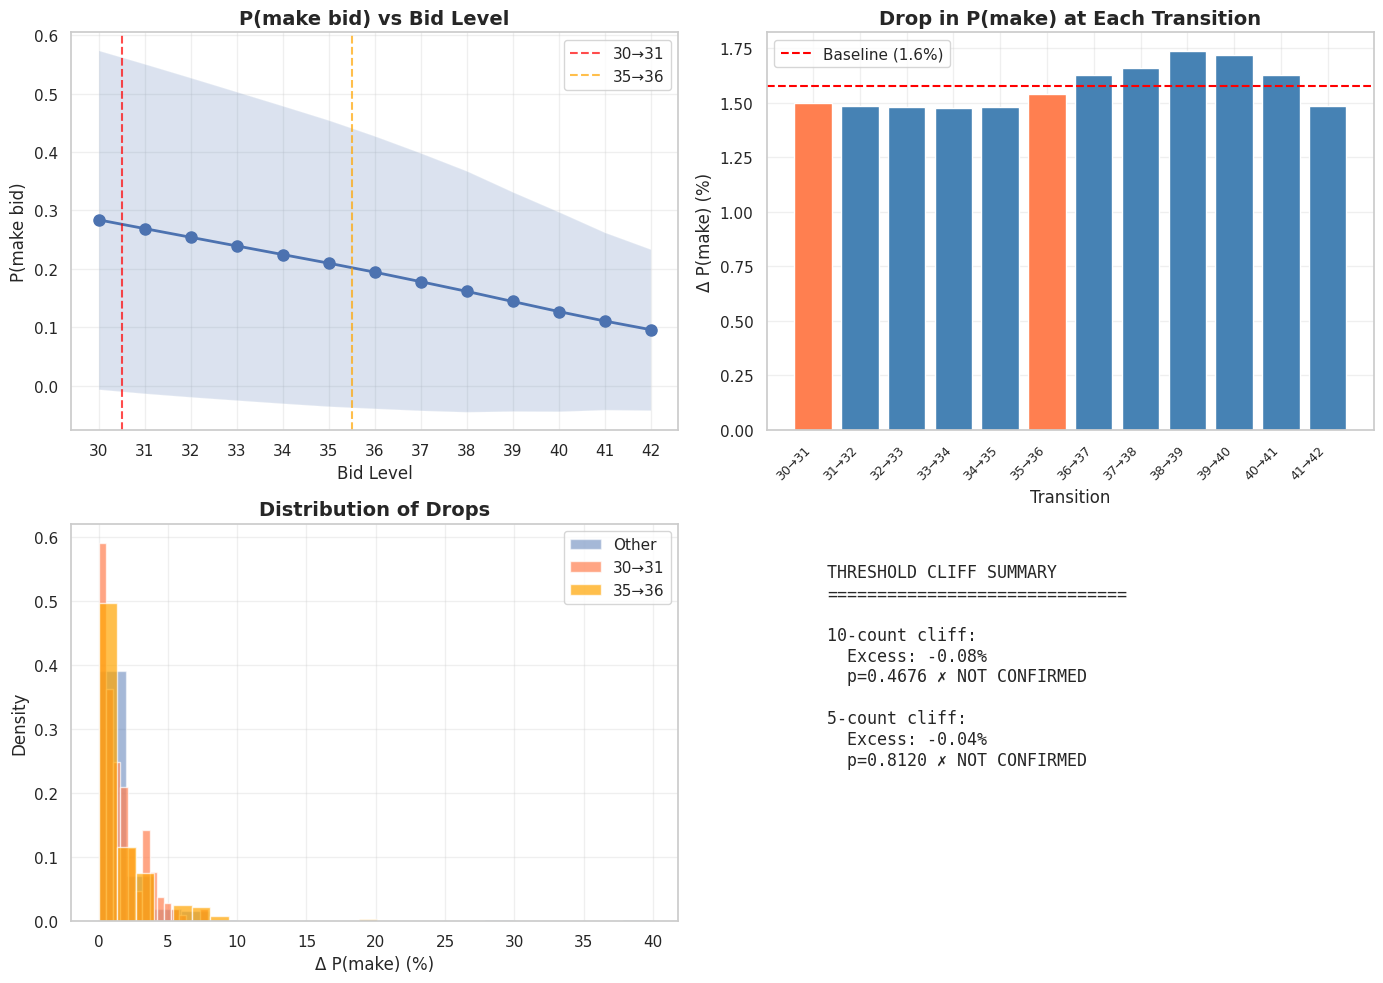

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: P(make) curve
ax = axes[0, 0]
bids = BID_LEVELS
p_means = [avg_p_make[b] for b in bids]
p_stds = [p_make_df[f'p_make_{b}'].std() for b in bids]
ax.plot(bids, p_means, 'b-o', linewidth=2, markersize=8)
ax.fill_between(bids, [m-s for m,s in zip(p_means, p_stds)], [m+s for m,s in zip(p_means, p_stds)], alpha=0.2)
ax.axvline(30.5, color='red', linestyle='--', alpha=0.7, label='30→31')
ax.axvline(35.5, color='orange', linestyle='--', alpha=0.7, label='35→36')
ax.set_xlabel('Bid Level')
ax.set_ylabel('P(make bid)')
ax.set_title('P(make bid) vs Bid Level', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(bids)

# Plot 2: Delta bar chart
ax = axes[0, 1]
labels = [f'{b}→{b+1}' for b in BID_LEVELS[:-1]]
means = [avg_deltas[(b, b+1)]['mean'] for b in BID_LEVELS[:-1]]
colors = ['coral' if b in [30, 35] else 'steelblue' for b in BID_LEVELS[:-1]]
ax.bar(range(len(labels)), [d*100 for d in means], color=colors)
ax.axhline(baseline_mean*100, color='red', linestyle='--', label=f'Baseline ({baseline_mean*100:.1f}%)')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_xlabel('Transition')
ax.set_ylabel('Δ P(make) (%)')
ax.set_title('Drop in P(make) at Each Transition', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Distribution comparison
ax = axes[1, 0]
key_30 = delta_df['delta_30_31'].values * 100
key_35 = delta_df['delta_35_36'].values * 100
others = delta_df[non_key_cols].values.flatten() * 100
ax.hist(others, bins=20, alpha=0.5, label='Other', density=True)
ax.hist(key_30, bins=15, alpha=0.7, label='30→31', color='coral', density=True)
ax.hist(key_35, bins=15, alpha=0.7, label='35→36', color='orange', density=True)
ax.set_xlabel('Δ P(make) (%)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Drops', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')
txt = "THRESHOLD CLIFF SUMMARY\n" + "="*30 + "\n\n"
for r in results:
    status = "✓ CONFIRMED" if r['significant'] else "✗ NOT CONFIRMED"
    txt += f"{r['description']}:\n  Excess: {r['excess']*100:+.2f}%\n  p={r['p_value']:.4f} {status}\n\n"
ax.text(0.1, 0.9, txt, transform=ax.transAxes, fontsize=12, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig('../../results/figures/26a_threshold_cliffs.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Save results
all_trans = []
for b_low, b_high in TRANSITIONS:
    col = f'delta_{b_low}_{b_high}'
    deltas = delta_df[col].values
    all_trans.append({
        'transition': f'{b_low}→{b_high}',
        'bid_from': b_low,
        'bid_to': b_high,
        'mean_delta_pct': deltas.mean() * 100,
        'std_delta_pct': deltas.std() * 100,
        'is_key_threshold': (b_low, b_high) in [(30, 31), (35, 36)],
        'excess_vs_baseline_pct': (deltas.mean() - baseline_mean) * 100
    })

results_df = pd.DataFrame(all_trans)
print(results_df.to_string(index=False))

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26a_threshold_cliffs.csv"
results_df.to_csv(output_path, index=False)
print(f"\nSaved to {output_path}")

transition  bid_from  bid_to  mean_delta_pct  std_delta_pct  is_key_threshold  excess_vs_baseline_pct
     30→31        30      31        1.498104       1.530471              True               -0.078964
     31→32        31      32        1.484243       1.571077             False               -0.092826
     32→33        32      33        1.480484       1.669273             False               -0.096585
     33→34        33      34        1.476224       1.754694             False               -0.100845
     34→35        34      35        1.479111       1.819502             False               -0.097957
     35→36        35      36        1.538824       2.264929              True               -0.038245
     36→37        36      37        1.627892       3.281915             False                0.050823
     37→38        37      38        1.657920       3.006406             False                0.080851
     38→39        38      39        1.735698       3.921759             False     

In [9]:
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print(f"\nHands analyzed: {len(features_df)}")
print(f"Baseline drop per bid point: {baseline_mean*100:.2f}%")
print("\nThreshold Cliff Results:")
for r in results:
    verdict = "CONFIRMED" if r['significant'] else "NOT CONFIRMED"
    print(f"  {r['description']}: {verdict} (excess {r['excess']*100:+.2f}%, p={r['p_value']:.4f})")


KEY INSIGHTS

Hands analyzed: 200
Baseline drop per bid point: 1.58%

Threshold Cliff Results:
  10-count cliff: NOT CONFIRMED (excess -0.08%, p=0.4676)
  5-count cliff: NOT CONFIRMED (excess -0.04%, p=0.8120)


## Key Findings

### Threshold Cliff Verification

Using normal approximation with V_mean and V_std:

**Folk Wisdom Claims:**
- 30→31 is "about losing one 10-count"
- 35→36 is "about losing one 5-count"

### Output Files

- `results/tables/26a_threshold_cliffs.csv` - Transition statistics
- `results/figures/26a_threshold_cliffs.png` - 4-panel visualization